# <center><font color=navy> Machine Learning from Theory to Practice</font></center>
### <center><font color=navy>High-Dimensional Covariance Matrix and Portfolio Estimation using Deep Autoencoders</font> </center>
### <center> Ali Habibnia</center>

    
<center> Assistant Professor, Department of Economics, </center>
<center> and Division of Computational Modeling & Data Analytics at Virginia Tech</center>
<center> habibnia@vt.edu </center> 

In [ ]:
import tensorflow as tf

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

# Check for GPU availability
print("GPU", "available (YES!)" if tf.config.list_physical_devices("GPU") else "not available :(")


TensorFlow Version: 2.13.0
GPU available (YES!)


In [ ]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 2


In [ ]:
from joblib import Parallel, delayed

In [ ]:
import numpy as np
import pandas as pd
import requests
import bs4 as bs
import datetime
import random
import yfinance as yf
import os
import pandas_datareader as web
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from scipy.integrate import quad
import statsmodels.formula.api as sm
from scipy.stats import multivariate_normal
from scipy.linalg import inv
import nonlinshrink as nls
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV, LedoitWolf, ShrunkCovariance, OAS

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, GaussianNoise, LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Synthetic Data Generation

In [ ]:
def generate_multivariate_returns(sample_size,
                                  start_date=datetime.datetime(2004, 1, 1), end_date=datetime.datetime(2016, 1, 1),
                                  number_of_companies=None, seed=None, plot_covRe=True, plot_covU=True, plot_cov_rv=True,
                                  plot_random_series=True, covariance_method='graphicallassocv', pre_downloaded_data=None):
    """
    Generates a multivariate returns series from a multivariate normal distribution MVN(0,covRe) with zero means and an
    estimated covariance matrix: covRe = sigma2_m * B @ B.T + covU based on historical data for the S&P 100 Index.
    We fit CAPM to the daily returns of each stock to get the coefficients B, and the covU is obtained by applying the
    shrinkage and soft-thresholding method (Rothman (2012)) to the sample covariance matrix of the residuals from fitting CAPM.

    Parameters:
    - sample_size: int, Number of samples for the return series
    - start_date: datetime, Start date for the data collection (default is 2004-01-01)
    - end_date: datetime, End date for the data collection (default is 2016-01-01)
    - number_of_companies: int, Number of randomly selected companies from S&P 100 that shows
       the dimension of the portfolio (default includes all companies in s&p 100)
    - seed: int, Random seed for reproducibility (default is None)
    - plot_covRe: bool, Whether to plot the heatmap of the estimated covariance for returns (covRe) (default is False)
    - plot_covU: bool, Whether to plot the heatmap of the covariance of residuals (covU) (default is False)
    - plot_cov_rv: bool, Whether to plot the heatmap of the covariance of generated random variables (rv) (default is False)
    - covariance_method (str, optional): The shrinkage and soft-thresholding method used to compute covU.
        Options include 'lw' for Ledoit-Wolf estimator, 'sc' for Shrunk covariance estimator, 'oas' for Oracle Approximating
        Shrinkage estimator, 'pds' for Positive definite sparse estimator, and 'graphicallassocv' for GraphicalLassoCV (default method).

    Returns:
    - DataFrame containing the generated multivariate returns series
    """
    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    historical_data = None
    # Getting the S&P 100 tickers from Wikipedia
    resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = [row.findAll('td')[0].text.replace('\n', '') for row in table.findAll('tr')[1:]]

    if seed is not None:
        np.random.seed(seed)

    if number_of_companies is not None:
        tickers = np.random.choice(tickers, number_of_companies, replace=False)

    # Define the file path on Google Drive
    file_path = "/content/drive/My Drive/financial_data.csv"

    # Downloading data from Yahoo finance
    if pre_downloaded_data is None:
        # Check if the data already exists in Drive
        if os.path.exists(file_path):
            # If data already exists in Drive, load it into historical_data
            historical_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        else:
            # If historical_data is None or data doesn't exist in Drive, download it
            historical_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
            historical_data.to_csv(file_path)  # Save data to Google Drive

        cleaned_data = historical_data.dropna(axis='columns', how='any').dropna(axis='index', how='any')
    else:
        cleaned_data = pre_downloaded_data

    Re = (np.log(cleaned_data.iloc[:, :-1]) - np.log(cleaned_data.iloc[:, :-1].shift(1))).dropna()
    # Reading factor data from Fama-French
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start=start_date, end=end_date)[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT'] / 100
    ##  Market return for S&P100 can also be retrived directly from Yahoo
    #market_returns = yf.download('^OEX', start=start_date, end=end_date)['Adj Close'].pct_change().dropna()

    # Compute CAPM and residuals
    coeffs = np.empty((Re.shape[1],1))
    residuals = np.empty((len(Re), 0))
    for i in range(Re.shape[1]):
        df_stk = Re.iloc[:, i]
        df_stock_factor = pd.merge(df_stk, df_factors, left_index=True, right_index=True)
        df_stock_factor['XsRet'] = df_stock_factor.iloc[:, 0] - df_stock_factor['RF']
        CAPM = sm.ols(formula='XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
        coeffs[i] = CAPM.params[1]
        residuals = np.hstack((residuals, CAPM.resid.values.reshape(-1, 1)))

    # Estimation of covU, sigma2_m, and covRe

    # Compute covU based on the selected method
    if covariance_method == 'lw':
        lw = LedoitWolf().fit(residuals)
        covU = lw.covariance_
    elif covariance_method == 'sc':
        sc = ShrunkCovariance().fit(residuals)
        covU = sc.covariance_
    elif covariance_method == 'oas':
        oas = OAS().fit(residuals)
        covU = oas.covariance_
    elif covariance_method == 'pds':
        sc = ShrunkCovariance().fit(residuals)
        oas = OAS().fit(residuals)
        alpha = 0.5  # regularization parameter
        covU = alpha * np.abs(sc.covariance_) + (1 - alpha) * oas.covariance_
    elif covariance_method == 'graphicallassocv':
        model_cov = GraphicalLassoCV()
        covU = model_cov.fit(residuals).covariance_
    else:
        raise ValueError(f"Unknown covariance_method: {covariance_method}")
    sigma2_m = np.var(df_factors['MKT'])
    B = coeffs.reshape(-1, 1)
    covRe = sigma2_m * B @ B.T + covU  # Estimated covariance matrix for returns

    # Generate multivariate returns
    rv = multivariate_normal(mean=np.zeros(len(covRe)), cov=covRe)
    multivariate_returns = rv.rvs(size=sample_size)

    # Convert to DataFrame
    return_series = pd.DataFrame(multivariate_returns, columns=[f'Asset_{i}' for i in range(1, len(covRe) + 1)])

    # Plot heatmaps if required
    if plot_covRe:
        sns.heatmap(covRe, robust=True)
        plt.title("Estimated Covariance of Returns (covRe)")
        plt.show()

    if plot_covU:
        sns.heatmap(covU, robust=True)
        plt.title("Covariance of Residuals (covU)")
        plt.show()

    if plot_cov_rv:
        sns.heatmap(np.cov(multivariate_returns, rowvar=False), robust=True)
        plt.title("Covariance of Generated Random Variables (rv)")
        plt.show()

    # Plot generated random series if required
    if plot_random_series:
        return_series.plot(title="Generated Random Series", figsize=(12,6), legend=False)
        plt.show()

    # Print head of return series
    #print(return_series.head())

    # Print covRe
    covRe_df = pd.DataFrame(covRe)
    #print(covRe_df.head())

    return return_series, covRe_df, coeffs, cleaned_data


[*********************100%%**********************]  101 of 101 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['DOW']: Exception("%ticker%: Data doesn't exist for startDate = 1072933200, endDate = 1451624400")
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


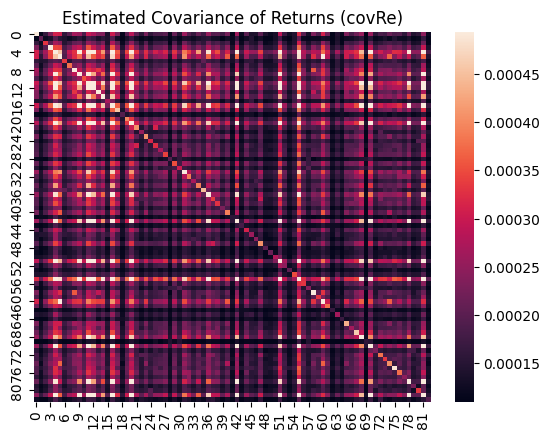

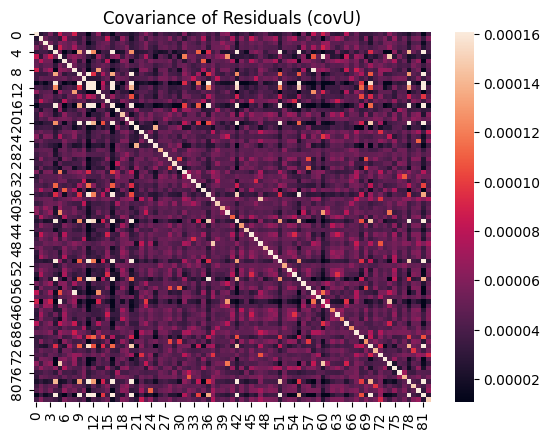

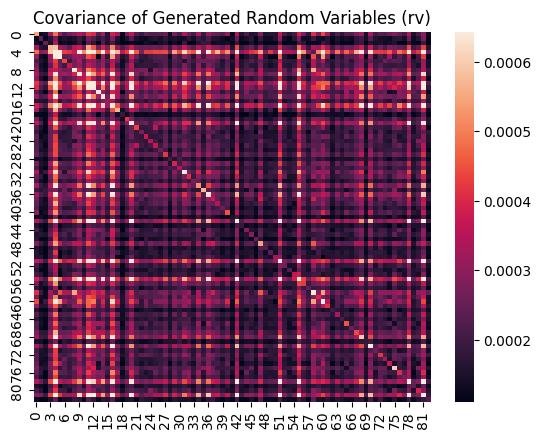

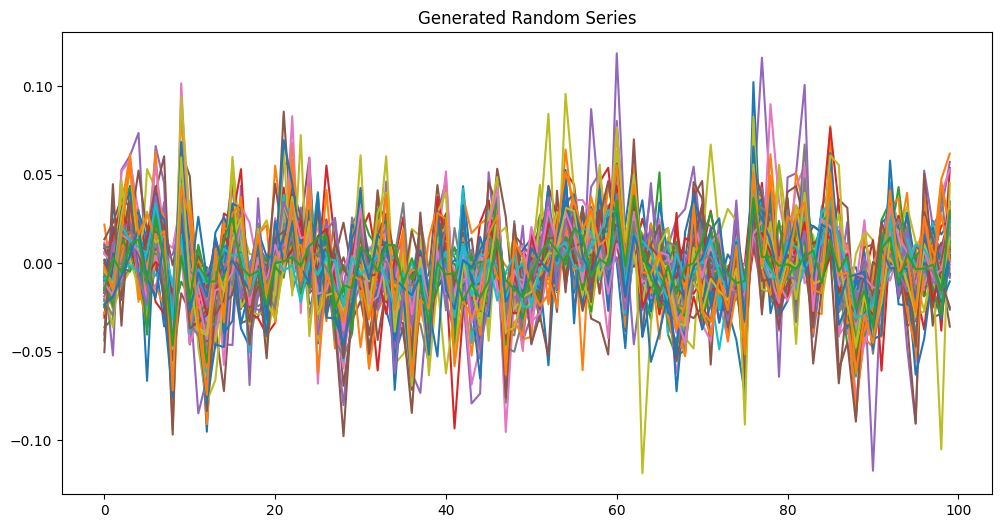

In [ ]:
sample = generate_multivariate_returns(sample_size = 100,
                                  start_date=datetime.datetime(2004, 1, 1), end_date=datetime.datetime(2016, 1, 1),
                                  number_of_companies=None, seed=None, plot_covRe=True, plot_covU=True, plot_cov_rv=True,
                                  plot_random_series=True, covariance_method='lw', pre_downloaded_data=None)

# Simiulation

Comparison of various MVP estimators. The mean and standard deviation (in parentheses) based on 1,000 replications of the Relative Risk ratio of estimated MVPs are reported. The number of assets is N = 84 and the sampling sizes are T = 50, 100
and 200. Monte Carlo with the assumption of normality.

In [ ]:
sample_sizes = [50,100,200]
methods = ['PlugIn', 'linear_shrinkage', 'non_linear_shrinkage', 'equally_weighted']

def Risk_Ratio_RR(covRe_df, estimated_portfolio_weights):
    '''
    evaluation is based on risk ratio (R.R.) defined as the ratio between the standard
    deviation of the return of an estimated portfolio, w^, and the minimum standard
    deviation.
    '''
    given_covariance_matrix = covRe_df
    inverse_given_covariance_matrix = inv(covRe_df)
    identity_matrix = np.ones(len(covRe_df))

    # Nominator Risk R(W^)
    nominator_risk = estimated_portfolio_weights.T @ given_covariance_matrix @ estimated_portfolio_weights

    # Denominator Risk R(W*) -> Rmin
    denominator_risk = 1 /(identity_matrix @ inverse_given_covariance_matrix @ identity_matrix)

    return np.sqrt((nominator_risk / denominator_risk))


def prepare_multivariate_parameters(start_date=datetime.datetime(2004, 1, 1), end_date=datetime.datetime(2016, 1, 1),
                                     number_of_companies=None, seed=None, covariance_method='graphicallassocv',
                                     pre_downloaded_data=None):
    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Getting the S&P 100 tickers from Wikipedia
    resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = [row.findAll('td')[0].text.replace('\n', '') for row in table.findAll('tr')[1:]]
    if seed is not None:
        np.random.seed(seed)
    if number_of_companies is not None:
        tickers = np.random.choice(tickers, number_of_companies, replace=False)

    # Downloading data from Yahoo finance
    if pre_downloaded_data is None:
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        cleaned_data = data.dropna(axis='columns', how='any').dropna(axis='index', how='any')
    else:
        cleaned_data = pre_downloaded_data

    Re = (np.log(cleaned_data.iloc[:, :-1]) - np.log(cleaned_data.iloc[:, :-1].shift(1))).dropna()
    # Reading factor data from Fama-French
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start=start_date, end=end_date)[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT'] / 100
    ##  Market return for S&P100 can also be retrived directly from Yahoo
    #market_returns = yf.download('^OEX', start=start_date, end=end_date)['Adj Close'].pct_change().dropna()

    # Compute CAPM and residuals
    coeffs = np.empty((Re.shape[1],1))
    residuals = np.empty((len(Re), 0))
    for i in range(Re.shape[1]):
        df_stk = Re.iloc[:, i]
        df_stock_factor = pd.merge(df_stk, df_factors, left_index=True, right_index=True)
        df_stock_factor['XsRet'] = df_stock_factor.iloc[:, 0] - df_stock_factor['RF']
        CAPM = sm.ols(formula='XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
        coeffs[i] = CAPM.params[1]
        residuals = np.hstack((residuals, CAPM.resid.values.reshape(-1, 1)))

    # Estimation of covU, sigma2_m, and covRe

    # Compute covU based on the selected method
    if covariance_method == 'lw':
        lw = LedoitWolf().fit(residuals)
        covU = lw.covariance_
    elif covariance_method == 'sc':
        sc = ShrunkCovariance().fit(residuals)
        covU = sc.covariance_
    elif covariance_method == 'oas':
        oas = OAS().fit(residuals)
        covU = oas.covariance_
    elif covariance_method == 'pds':
        sc = ShrunkCovariance().fit(residuals)
        oas = OAS().fit(residuals)
        alpha = 0.5  # regularization parameter
        covU = alpha * np.abs(sc.covariance_) + (1 - alpha) * oas.covariance_
    elif covariance_method == 'graphicallassocv':
        model_cov = GraphicalLassoCV()
        covU = model_cov.fit(residuals).covariance_
    else:
        raise ValueError(f"Unknown covariance_method: {covariance_method}")
    sigma2_m = np.var(df_factors['MKT'])
    B = coeffs.reshape(-1, 1)
    covRe = sigma2_m * B @ B.T + covU  # Estimated covariance matrix for returns

    return covRe, len(covRe)

def generate_multivariate_returns2(covRe, sample_size):
    # Generate multivariate returns
    rv = multivariate_normal(mean=np.zeros(len(covRe)), cov=covRe)
    multivariate_returns = rv.rvs(size=sample_size)
    # Convert to DataFrame
    return_series = pd.DataFrame(multivariate_returns, columns=[f'Asset_{i}' for i in range(1, len(covRe) + 1)])

    return return_series


covRe, length_covRe = prepare_multivariate_parameters(covariance_method='pds')

# Create a DataFrame to hold the results
results_df = pd.DataFrame(columns=['Portfolio', 'T=50', 'T=100', 'T=200'])

# Loop through each method and sample size
for method in methods:
    row_data = [method]
    for sample_size in sample_sizes:
        risk_ratios = [] # List to store the risk ratios

        for _ in range(1000): # Run 1000 simulations
            return_series = generate_multivariate_returns2(covRe, sample_size=sample_size)
            identity_matrix = np.ones(len(covRe))
            sample_cov_matrix = return_series.cov()

            # Calculate the estimated portfolio weights based on the selected method
            if method == 'PlugIn':
                estimated_portfolio_weights = (inv(sample_cov_matrix) @ identity_matrix) / (identity_matrix.T @ inv(sample_cov_matrix) @ identity_matrix)
            elif method == 'linear_shrinkage':
                shrunk_cov = LedoitWolf().fit(return_series).covariance_
                estimated_portfolio_weights = (inv(shrunk_cov) @ identity_matrix) / (identity_matrix.T @ inv(shrunk_cov) @ identity_matrix)
            elif method == 'non_linear_shrinkage':
                sigma_tilde = nls.shrink_cov(return_series)
                estimated_portfolio_weights = (inv(sigma_tilde) @ identity_matrix) / (identity_matrix.T @ inv(sigma_tilde) @ identity_matrix)
            elif method == 'equally_weighted':
                cov_matrix = np.eye(len(covRe), len(covRe))
                estimated_portfolio_weights = (inv(cov_matrix) @ identity_matrix) / (identity_matrix.T @ inv(cov_matrix) @ identity_matrix)

            risk_ratio = Risk_Ratio_RR(covRe, estimated_portfolio_weights)
            risk_ratios.append(risk_ratio)

        average_risk_ratio = np.mean(risk_ratios)
        std_dev_risk_ratio = np.std(risk_ratios)

        row_data.append(f"{average_risk_ratio} ({std_dev_risk_ratio})")

    results_df.loc[len(results_df)] = row_data

table = tabulate(results_df, headers='keys', tablefmt='pipe', stralign='center')
print(table)

[*********************100%%**********************]  101 of 101 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:['DOW']: Exception("%ticker%: Data doesn't exist for startDate = 1072933200, endDate = 1451624400")



|    |      Portfolio       |                    T=50                    |                   T=100                    |                   T=200                    |
|---:|:--------------------:|:------------------------------------------:|:------------------------------------------:|:------------------------------------------:|
|  0 |        PlugIn        |   27.897582962443657 (50.62728326444394)   |  2.7481667290369125 (0.7573857684806268)   |  1.2897236307046933 (0.05509805969825081)  |
|  1 |   linear_shrinkage   |  1.3188233778236789 (0.04851555968286465)  | 1.3347197932548938 (0.056170650243386536)  | 1.2002139993365284 (0.034323648859447116)  |
|  2 | non_linear_shrinkage | 1.2292017113571887 (0.045163715746911796)  | 1.1729339507613656 (0.034784801651526594)  |  1.1171589141061316 (0.01792465317479751)  |
|  3 |   equally_weighted   | 1.4937999475299466 (2.220446049250313e-16) | 1.4937999475299466 (2.220446049250313e-16) | 1.4937999475299466 (2.220446049250313e-16) |


## Autoencoder to learn Cov based on roalling covariance

Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping
Epoch 1/200, Loss: 0.011756897903978825, Val Loss: 0.003946362994611263
Epoch 11/200, Loss: 0.0006801295676268637, Val Loss: 0.001637631910853088
Epoch 21/200, Loss: 0.0006704273982904851, Val Loss: 0.0018258144846186042
10/10 [==============================] - 0s 2ms/step


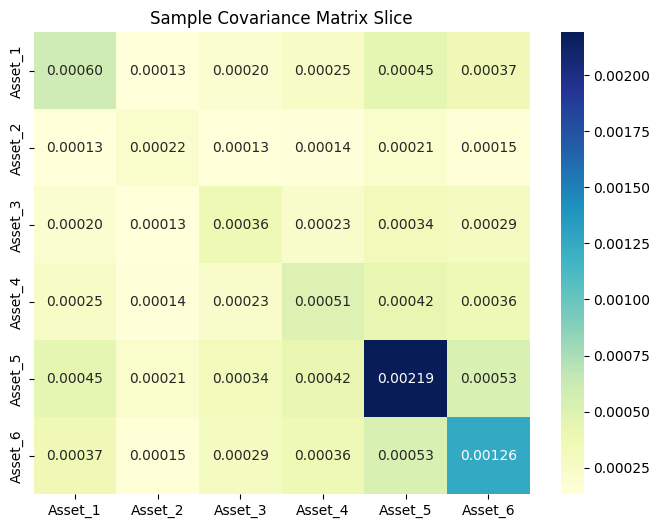

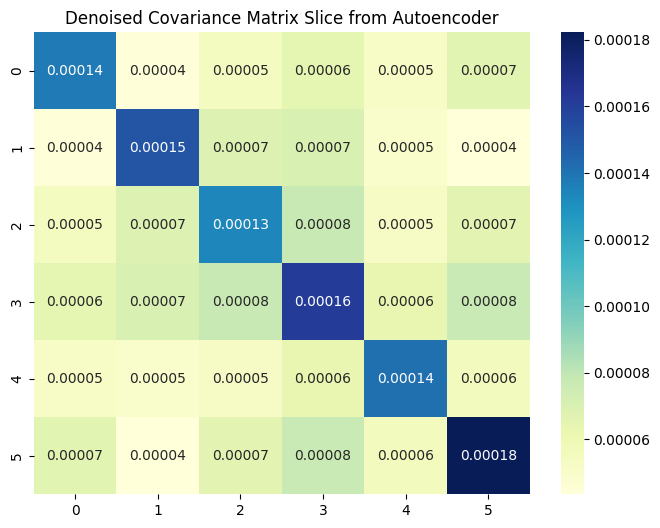

In [ ]:
train_data2 = generate_multivariate_returns2(covRe, sample_size=1000)
returns = train_data2.copy()

sample_cov_matrix = returns.cov()

train_length = int(0.7 * len(returns))
window_length = int(0.3 * len(returns))

def create_training_data(returns, window_length=window_length):
    """
    Convert returns dataframe into a training dataset.
    Each row in the dataset represents a flattened upper-triangle of a correlation matrix.
    """
    num_assets = len(returns.columns)
    num_entries = int(num_assets * (num_assets + 1) / 2)
    training_data = []

    for i in range(len(returns) - window_length + 1):
        window = returns.iloc[i:i+window_length]
        cov_matrix = window.cov()
        corr_matrix = window.corr()

        # Extract the upper triangle of the correlation matrix
        upper_triangle = corr_matrix.values[np.triu_indices(num_assets)]
        variances = np.diag(cov_matrix)

        combined = np.concatenate([upper_triangle, variances])
        training_data.append(combined)

    return training_data

# Create training and test datasets
training_data = create_training_data(returns[:train_length])
test_data = create_training_data(returns[train_length-window_length:])  # To include the overlapg

# Convert lists to numpy arrays
X_train = np.array(training_data)
X_test = np.array(test_data)

# Add some noise to the training data
noise_factor = 0.5
noisy_X_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
noisy_X_test = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

noisy_X_train = np.clip(noisy_X_train, 0., 1.)
noisy_X_test = np.clip(noisy_X_test, 0., 1.)

# Autoencoder architecture
input_dim = X_train.shape[1]

# Encoder
input_layer = Input(shape=(input_dim,))
hidden_1 = Dense(128, activation='relu')(input_layer)
hidden_2 = Dense(64, activation='relu')(hidden_1)
hidden_3 = Dense(8, activation='relu')(hidden_2)
encoded = Dense(1, activation='sigmoid')(hidden_3)  # Reduced size for encoded layer

# Decoder
decoder_hidden_3 = Dense(8, activation='relu')(encoded)
decoder_hidden_2 = Dense(64, activation='relu')(decoder_hidden_3)
decoder_hidden_1 = Dense(128, activation='relu')(decoder_hidden_2)
decoded = Dense(input_dim, activation='sigmoid')(decoder_hidden_1)

autoencoder = Model(input_layer, decoded)

# Separately defining the encoder
encoder = Model(input_layer, encoded)

# Building the decoder using the layers from the autoencoder
encoded_input = Input(shape=(1,))  # This must match the size of the encoded layer
decoder_layer_hidden_3 = autoencoder.layers[-4](encoded_input)
decoder_layer_hidden_2 = autoencoder.layers[-3](decoder_layer_hidden_3)
decoder_layer_hidden_1 = autoencoder.layers[-2](decoder_layer_hidden_2)
decoder_layer = autoencoder.layers[-1](decoder_layer_hidden_1)
decoder = Model(encoded_input, decoder_layer)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Training loop
n_epochs = 200
history = autoencoder.fit(noisy_X_train, X_train, validation_data=(noisy_X_test, X_test),
                          epochs=n_epochs, batch_size=10, shuffle=True,
                          callbacks=[early_stopping], verbose=0)

for epoch, loss, val_loss in zip(range(n_epochs), history.history['loss'], history.history['val_loss']):
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss}, Val Loss: {val_loss}")

def plot_covariance_matrix_with_heatmap(covmat, names, title=None, file_name=None):
    #plt.figure(figsize=(20, 16))
    ax = sns.heatmap(covmat, annot=False, robust=True)
    plt.title(title)
    plt.show()


def plot_covariance_matrix_with_heatmap_slice(covmat, title=None, file_name=None, slice_size=6):
    """
    Plots the first `slice_size` x `slice_size` slice of the given covariance matrix.
    """
    slice_covmat = covmat.iloc[:slice_size, :slice_size]  # Extract the slice

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(slice_covmat, annot=True, fmt=".5f", cmap='YlGnBu')  # Format to display 2 decimal places
    plt.title(title if title else "Covariance Matrix Slice")

    if file_name:
        plt.savefig(file_name)
    plt.show()

# Decoding the autoencoder's output to obtain the denoised covariance matrix
decoded_data = autoencoder.predict(X_test)
num_assets = len(returns.columns)
reconstructed_matrices = []

for entry in decoded_data:
    corr_upper_triangle = entry[:int(num_assets * (num_assets + 1) / 2)]
    variances = entry[int(num_assets * (num_assets + 1) / 2):]

    corr_matrix = np.zeros((num_assets, num_assets))
    indices = np.triu_indices(num_assets)
    corr_matrix[indices] = corr_upper_triangle
    corr_matrix = corr_matrix + corr_matrix.T - np.diag(np.diag(corr_matrix))
    cov_matrix = np.diag(variances) @ corr_matrix @ np.diag(variances)
    reconstructed_matrices.append(cov_matrix)

# Assuming the sample covariance matrix and the reconstructed matrix are pandas DataFrames:
sample_cov_matrix = returns.cov()

# Plot the 10x10 slice of the sample covariance matrix
plot_covariance_matrix_with_heatmap_slice(sample_cov_matrix, "Sample Covariance Matrix Slice")

# Plot the 10x10 slice of the denoised covariance matrix
reconstructed_df = pd.DataFrame(reconstructed_matrices[-1])
plot_covariance_matrix_with_heatmap_slice(reconstructed_df, "Denoised Covariance Matrix Slice from Autoencoder")


# Plot the last sample covariance matrix
#plot_covariance_matrix_with_heatmap(sample_cov_matrix, "Sample Covariance Matrix")

# Plot the denoised covariance matrix
#plot_covariance_matrix_with_heatmap(reconstructed_matrices[-1], "Denoised Covariance Matrix from Autoencoder")

In [ ]:
# 1. For the sample covariance matrix:
sample_cov_matrix = returns.cov()
print(f"Sample Covariance Matrix:")
print(f"Min: {sample_cov_values.min()}")
print(f"Max: {sample_cov_values.max()}")
print(f"Average: {sample_cov_values.mean()}")
print("-------------")

# 2. For the reconstructed matrices:
reconstructed_values = np.array(reconstructed_matrices).flatten()
print(f"Reconstructed Matrices:")
print(f"Min: {reconstructed_values.min()}")
print(f"Max: {reconstructed_values.max()}")
print(f"Average: {reconstructed_values.mean()}")


In [ ]:
sample_sizes = [50,100,200]
methods = ['PlugIn', 'linear_shrinkage', 'non_linear_shrinkage', 'equally_weighted', 'autoencoder']

def Risk_Ratio_RR(covRe_df, estimated_portfolio_weights):
    '''
    evaluation is based on risk ratio (R.R.) defined as the ratio between the standard
    deviation of the return of an estimated portfolio, w^, and the minimum standard
    deviation.
    '''
    given_covariance_matrix = covRe_df
    inverse_given_covariance_matrix = inv(covRe_df)
    identity_matrix = np.ones(len(covRe_df))

    # Nominator Risk R(W^)
    nominator_risk = estimated_portfolio_weights.T @ given_covariance_matrix @ estimated_portfolio_weights

    # Denominator Risk R(W*) -> Rmin
    denominator_risk = 1 /(identity_matrix @ inverse_given_covariance_matrix @ identity_matrix)

    return np.sqrt((nominator_risk / denominator_risk))

historical_data = None

def prepare_multivariate_parameters(start_date=datetime.datetime(2004, 1, 1), end_date=datetime.datetime(2016, 1, 1),
                                     number_of_companies=None, seed=None, covariance_method='graphicallassocv',
                                     pre_downloaded_data=None):
    global historical_data

    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Getting the S&P 100 tickers from Wikipedia
    resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = [row.findAll('td')[0].text.replace('\n', '') for row in table.findAll('tr')[1:]]

    if seed is not None:
        np.random.seed(seed)

    if number_of_companies is not None:
        tickers = np.random.choice(tickers, number_of_companies, replace=False)

    # Define the file path on Google Drive
    file_path = "/content/drive/My Drive/financial_data.csv"

    # Downloading data from Yahoo finance
    if pre_downloaded_data is None:
        # Check if the data already exists in Drive
        if os.path.exists(file_path):
            # If data already exists in Drive, load it into historical_data
            historical_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        else:
            # If historical_data is None or data doesn't exist in Drive, download it
            historical_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
            historical_data.to_csv(file_path)  # Save data to Google Drive

        cleaned_data = historical_data.dropna(axis='columns', how='any').dropna(axis='index', how='any')
    else:
        cleaned_data = pre_downloaded_data

    Re = (np.log(cleaned_data.iloc[:, :-1]) - np.log(cleaned_data.iloc[:, :-1].shift(1))).dropna()
    # Reading factor data from Fama-French
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start=start_date, end=end_date)[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT'] / 100
    ##  Market return for S&P100 can also be retrived directly from Yahoo
    #market_returns = yf.download('^OEX', start=start_date, end=end_date)['Adj Close'].pct_change().dropna()

    # Compute CAPM and residuals
    coeffs = np.empty((Re.shape[1],1))
    residuals = np.empty((len(Re), 0))
    for i in range(Re.shape[1]):
        df_stk = Re.iloc[:, i]
        df_stock_factor = pd.merge(df_stk, df_factors, left_index=True, right_index=True)
        df_stock_factor['XsRet'] = df_stock_factor.iloc[:, 0] - df_stock_factor['RF']
        CAPM = sm.ols(formula='XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
        coeffs[i] = CAPM.params[1]
        residuals = np.hstack((residuals, CAPM.resid.values.reshape(-1, 1)))

    # Estimation of covU, sigma2_m, and covRe

    # Compute covU based on the selected method
    if covariance_method == 'lw':
        lw = LedoitWolf().fit(residuals)
        covU = lw.covariance_
    elif covariance_method == 'sc':
        sc = ShrunkCovariance().fit(residuals)
        covU = sc.covariance_
    elif covariance_method == 'oas':
        oas = OAS().fit(residuals)
        covU = oas.covariance_
    elif covariance_method == 'pds':
        sc = ShrunkCovariance().fit(residuals)
        oas = OAS().fit(residuals)
        alpha = 0.5  # regularization parameter
        covU = alpha * np.abs(sc.covariance_) + (1 - alpha) * oas.covariance_
    elif covariance_method == 'graphicallassocv':
        model_cov = GraphicalLassoCV()
        covU = model_cov.fit(residuals).covariance_
    else:
        raise ValueError(f"Unknown covariance_method: {covariance_method}")
    sigma2_m = np.var(df_factors['MKT'])
    B = coeffs.reshape(-1, 1)
    covRe = sigma2_m * B @ B.T + covU  # Estimated covariance matrix for returns

    return covRe, len(covRe)

def generate_multivariate_returns2(covRe, sample_size):
    # Generate multivariate returns
    rv = multivariate_normal(mean=np.zeros(len(covRe)), cov=covRe)
    multivariate_returns = rv.rvs(size=sample_size)
    # Convert to DataFrame
    return_series = pd.DataFrame(multivariate_returns, columns=[f'Asset_{i}' for i in range(1, len(covRe) + 1)])

    return return_series


covRe, length_covRe = prepare_multivariate_parameters(covariance_method='pds')

# Create a DataFrame to hold the results
results_df = pd.DataFrame(columns=['Portfolio', 'T=50', 'T=100', 'T=200'])

# Generate training data for the autoencoder using the largest sample size
train_data = generate_multivariate_returns2(covRe, sample_size=100)   #sample_size = max(sample_sizes)
returns = train_data.copy()

# Split the data for training and testing and define the window size for the covariance
train_length = int(1 * len(returns))
window_length = int(0.3 * len(returns))


def create_training_data(returns, window_length=window_length):
    """
    Convert returns dataframe into a training dataset.
    Each row in the dataset represents a flattened upper-triangle of a correlation matrix.
    """
    num_assets = len(returns.columns)
    num_entries = int(num_assets * (num_assets + 1) / 2)
    training_data = []

    for i in range(len(returns) - window_length + 1):
        window = returns.iloc[i:i+window_length]
        cov_matrix = window.cov()
        corr_matrix = window.corr()

        # Extract the upper triangle of the correlation matrix
        upper_triangle = corr_matrix.values[np.triu_indices(num_assets)]
        variances = np.diag(cov_matrix)

        combined = np.concatenate([upper_triangle, variances])
        training_data.append(combined)

    return training_data

training_data = create_training_data(returns[:train_length], window_length=window_length)
test_data = create_training_data(returns[train_length-window_length:])

X_train = np.array(training_data)
X_test = np.array(test_data)

# Add some noise to the training data
noise_factor = 0.5
noisy_X_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
noisy_X_test = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

noisy_X_train = np.clip(noisy_X_train, 0., 1.)
noisy_X_test = np.clip(noisy_X_test, 0., 1.)

# Define the autoencoder architecture
input_dim = X_train.shape[1]

'''
# Encoder
input_layer = Input(shape=(input_dim,))
hidden_1 = Dense(2048, activation='relu')(input_layer)
hidden_2 = Dense(512, activation='relu')(hidden_1)
hidden_3 = Dense(256, activation='relu')(hidden_2)
encoded = Dense(1, activation='sigmoid')(hidden_3)  # Reduced size for encoded layer

# Decoder
decoder_hidden_3 = Dense(256, activation='relu')(encoded)
decoder_hidden_2 = Dense(512, activation='relu')(decoder_hidden_3)
decoder_hidden_1 = Dense(2048, activation='relu')(decoder_hidden_2)
decoded = Dense(input_dim, activation='sigmoid')(decoder_hidden_1)

autoencoder = Model(input_layer, decoded)

# Separately defining the encoder
encoder = Model(input_layer, encoded)

# Building the decoder using the layers from the autoencoder
encoded_input = Input(shape=(1,))  # This must match the size of the encoded layer
decoder_layer_hidden_3 = autoencoder.layers[-4](encoded_input)
decoder_layer_hidden_2 = autoencoder.layers[-3](decoder_layer_hidden_3)
decoder_layer_hidden_1 = autoencoder.layers[-2](decoder_layer_hidden_2)
decoder_layer = autoencoder.layers[-1](decoder_layer_hidden_1)
decoder = Model(encoded_input, decoder_layer)
'''
# Encoder
input_layer = Input(shape=(input_dim,))
hidden_1 = Dense(1, activation='relu')(input_layer)  # One hidden layer
encoded = Dense(1, activation='sigmoid')(hidden_1)  # Reduced size for encoded layer

# Decoder
decoder_hidden_1 = Dense(1, activation='relu')(encoded)  # One hidden layer
decoded = Dense(input_dim, activation='sigmoid')(decoder_hidden_1)

autoencoder = Model(input_layer, decoded)

# Separately defining the encoder
encoder = Model(input_layer, encoded)

# Building the decoder using the layers from the autoencoder
encoded_input = Input(shape=(1,))  # This must match the size of the encoded layer
decoder_layer_hidden_1 = autoencoder.layers[-2](encoded_input)
decoder_layer = autoencoder.layers[-1](decoder_layer_hidden_1)
decoder = Model(encoded_input, decoder_layer)



# Compile and train the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.000000005), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

n_epochs = 200
history = autoencoder.fit(noisy_X_train, X_train, validation_data=(noisy_X_test, X_test),
                          epochs=n_epochs, batch_size=10, shuffle=True,
                          callbacks=[early_stopping], verbose=0)

# If you want to see the training progress, you can print out the loss values
for epoch, loss, val_loss in zip(range(n_epochs), history.history['loss'], history.history['val_loss']):
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss}, Val Loss: {val_loss}")

# Loop through each method and sample size
for method in methods:
    row_data = [method]
    for sample_size in sample_sizes:
        risk_ratios = [] # List to store the risk ratios

        for _ in range(10): # Run 1000 simulations
            return_series = generate_multivariate_returns2(covRe, sample_size=sample_size)
            identity_matrix = np.ones(len(covRe))
            sample_cov_matrix = return_series.cov()

            # Calculate the estimated portfolio weights based on the selected method
            if method == 'PlugIn':
                estimated_portfolio_weights = (inv(sample_cov_matrix) @ identity_matrix) / (identity_matrix.T @ inv(sample_cov_matrix) @ identity_matrix)
            elif method == 'autoencoder':
                # Denoise the sample covariance matrix using the autoencoder
                reshaped_data = create_training_data(return_series, window_length=sample_size)  # Assuming your window_length is equal to sample size, adjust otherwise
                decoded_data = autoencoder.predict(np.array(reshaped_data))

                # Convert the autoencoder's output to a covariance matrix
                reconstructed_matrices = []
                for entry in decoded_data:
                    corr_upper_triangle = entry[:int(length_covRe * (length_covRe + 1) / 2)]
                    variances = entry[int(length_covRe * (length_covRe + 1) / 2):]
                    corr_matrix = np.zeros((length_covRe, length_covRe))
                    indices = np.triu_indices(length_covRe)
                    corr_matrix[indices] = corr_upper_triangle
                    corr_matrix = corr_matrix + corr_matrix.T - np.diag(np.diag(corr_matrix))
                    cov_matrix = np.diag(variances) @ corr_matrix @ np.diag(variances)
                    reconstructed_matrices.append(cov_matrix)

                denoised_cov_matrix = reconstructed_matrices[-1]  # Take the last one if multiple, or average them if needed
                estimated_portfolio_weights = (inv(denoised_cov_matrix) @ identity_matrix) / (identity_matrix.T @ inv(denoised_cov_matrix) @ identity_matrix)
            elif method == 'linear_shrinkage':
                shrunk_cov = LedoitWolf().fit(return_series).covariance_
                estimated_portfolio_weights = (inv(shrunk_cov) @ identity_matrix) / (identity_matrix.T @ inv(shrunk_cov) @ identity_matrix)
            elif method == 'non_linear_shrinkage':
                sigma_tilde = nls.shrink_cov(return_series)
                estimated_portfolio_weights = (inv(sigma_tilde) @ identity_matrix) / (identity_matrix.T @ inv(sigma_tilde) @ identity_matrix)
            elif method == 'equally_weighted':
                cov_matrix = np.eye(len(covRe), len(covRe))
                estimated_portfolio_weights = (inv(cov_matrix) @ identity_matrix) / (identity_matrix.T @ inv(cov_matrix) @ identity_matrix)

            risk_ratio = Risk_Ratio_RR(covRe, estimated_portfolio_weights)
            risk_ratios.append(risk_ratio)

        average_risk_ratio = np.mean(risk_ratios)
        std_dev_risk_ratio = np.std(risk_ratios)

        row_data.append(f"{average_risk_ratio} ({std_dev_risk_ratio})")

    results_df.loc[len(results_df)] = row_data

table = tabulate(results_df, headers='keys', tablefmt='pipe', stralign='center')
print(table)

## Autoencoder with Linear Decoder

[*********************100%%**********************]  19 of 19 completed
Epoch 1/30
61/61 [==============================] - 2s 6ms/step - loss: 0.1853 - val_loss: 0.1494
Epoch 2/30
61/61 [==============================] - 0s 4ms/step - loss: 0.1270 - val_loss: 0.1015
Epoch 3/30
61/61 [==============================] - 0s 4ms/step - loss: 0.0860 - val_loss: 0.0677
Epoch 4/30
61/61 [==============================] - 0s 6ms/step - loss: 0.0570 - val_loss: 0.0439
Epoch 5/30
61/61 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.0273
Epoch 6/30
61/61 [==============================] - 0s 4ms/step - loss: 0.0227 - val_loss: 0.0161
Epoch 7/30
61/61 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.0091
Epoch 8/30
61/61 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 9/30
61/61 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 10/30
61/61 [============================

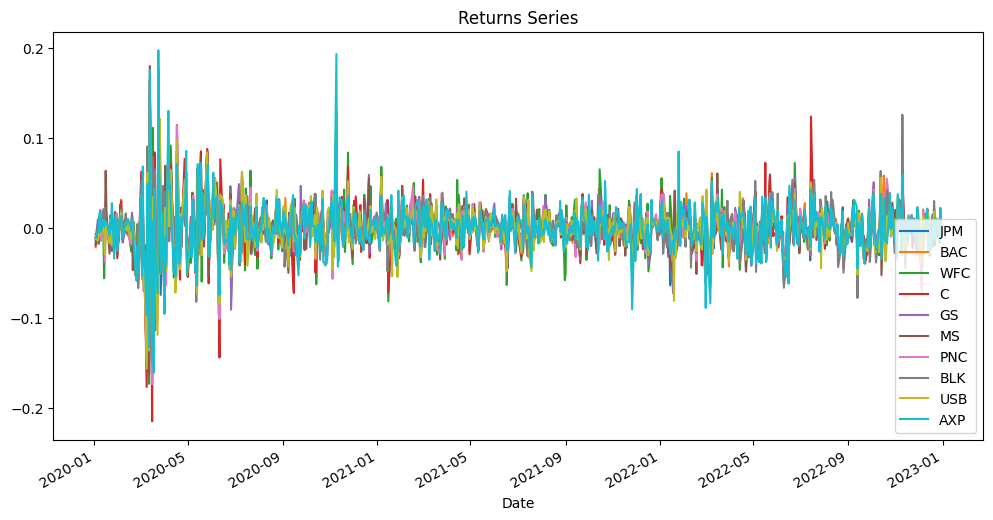

24/24 [==============================] - 0s 2ms/step


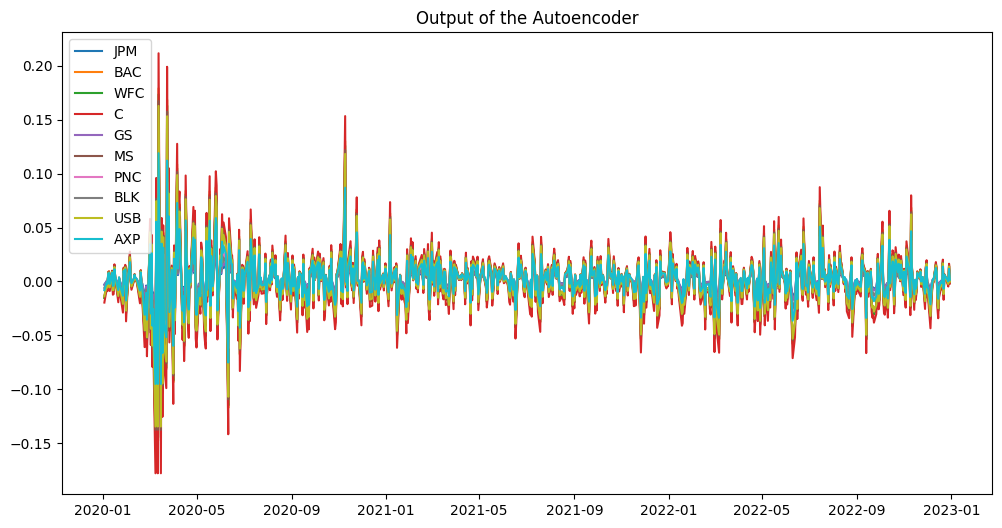

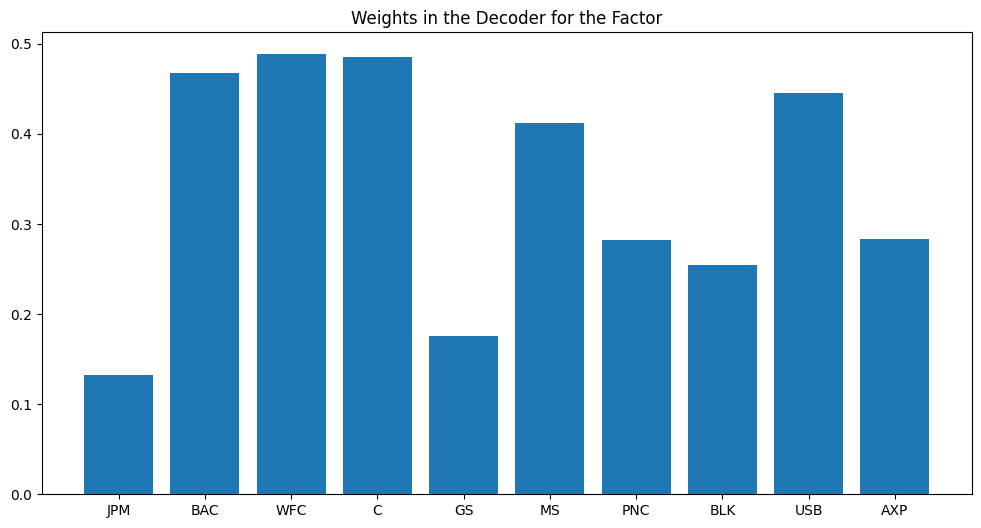

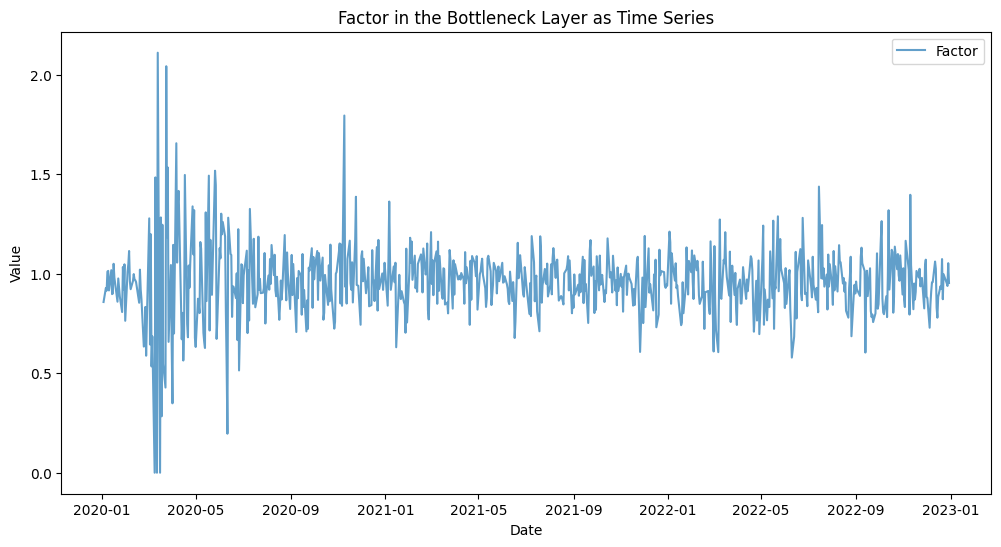

In [ ]:
# Scale the returns data between 0 and 1
scaler = MinMaxScaler()
returns_scaled = scaler.fit_transform(return_series)

input_size = return_series.shape[1]

# 3. Define the asymmetric autoencoder
input_layer = Input(shape=(input_size,))
encoder_hidden1 = Dense(4, activation='relu')(input_layer)
encoder_hidden2 = Dense(2, activation='relu')(encoder_hidden1)
bottleneck = Dense(1, activation='relu')(encoder_hidden2)
decoder_output = Dense(input_size, activation='linear')(bottleneck)

autoencoder = Model(inputs=input_layer, outputs=decoder_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(returns_scaled, returns_scaled, epochs=30, batch_size=10, validation_split=0.2)

# Extract the encoder
encoder = Model(inputs=input_layer, outputs=bottleneck)

# Encode the data
encoded_data = encoder.predict(returns_scaled)

# 4. Plotting
# Plot returns series
returns.plot(figsize=(12, 6))
plt.title('Returns Series')
plt.show()

# Plot the output of the autoencoder
decoded_data = autoencoder.predict(returns_scaled)
decoded_returns = scaler.inverse_transform(decoded_data)
plt.figure(figsize=(12, 6))
plt.plot(returns.index, decoded_returns)
plt.title('Output of the Autoencoder')
plt.legend(selected_tickers)
plt.show()

# Extract the weights from the decoder layer
weights = autoencoder.layers[-1].get_weights()[0]

# Plot the weights in the decoder for the neuron in the bottleneck layer
plt.figure(figsize=(12, 6))
plt.bar(range(input_size), weights[0, :])
plt.xticks(range(input_size), selected_tickers)
plt.title('Weights in the Decoder for the Factor')
plt.show()

# Plot the factor in the bottleneck layer as time series
plt.figure(figsize=(12, 6))
plt.plot(returns.index, encoded_data, label='Factor', alpha=0.7)
plt.title('Factor in the Bottleneck Layer as Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# Covariance matrix estimation based on single-factor model
factor_var = np.var(encoded_data)
cov_matrix = np.outer(weights, weights) * factor_var
idiosyncratic_var = np.var(returns_scaled - decoded_data, axis=0)
np.fill_diagonal(cov_matrix, np.diag(cov_matrix) + idiosyncratic_var)


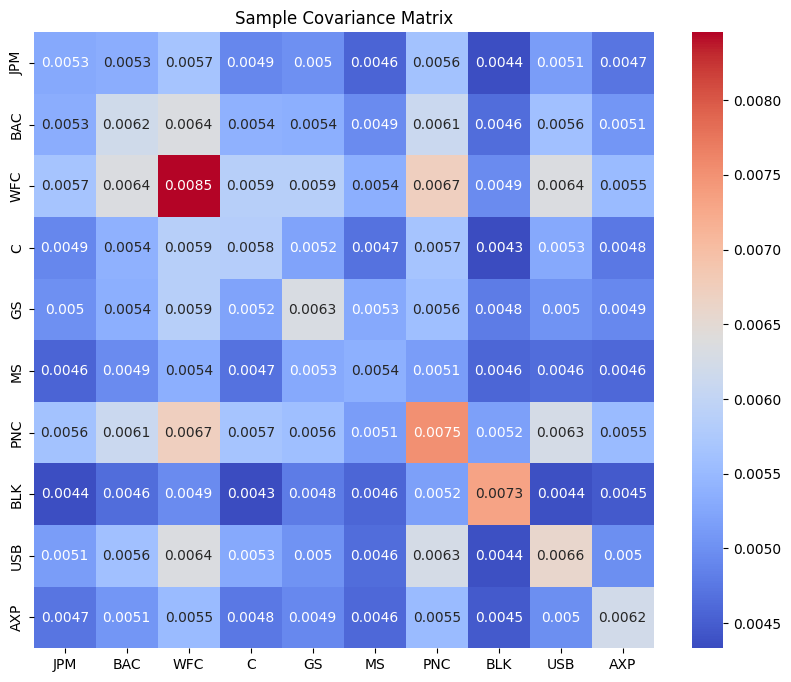

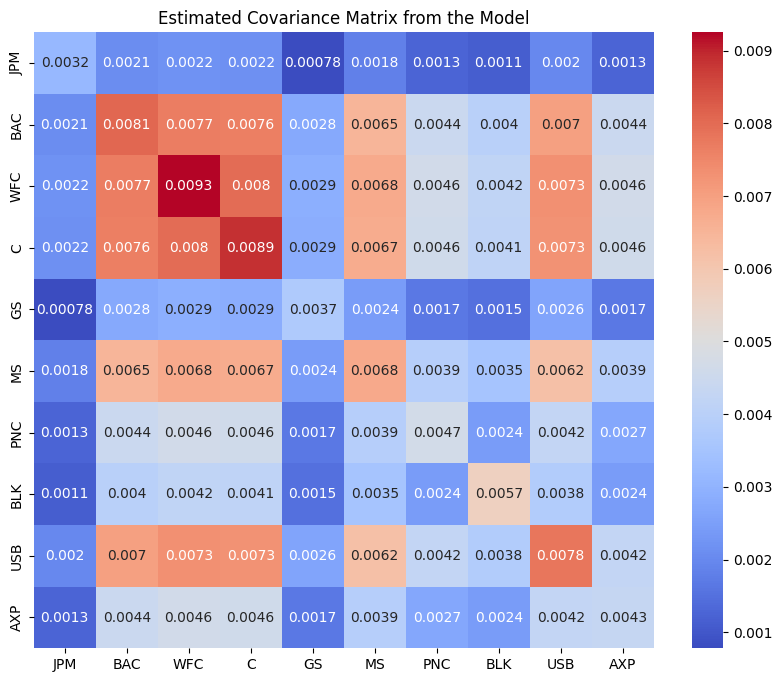

In [ ]:
# If you want to visualize the covariance matrices using heatmaps:
import seaborn as sns

# Sample covariance matrix
sample_cov_matrix = np.cov(returns_scaled, rowvar=False)

# Heatmap for the sample covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(sample_cov_matrix, annot=True, cmap='coolwarm', xticklabels=selected_tickers, yticklabels=selected_tickers)
plt.title('Sample Covariance Matrix')
plt.show()

# Heatmap for the estimated covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', xticklabels=selected_tickers, yticklabels=selected_tickers)
plt.title('Estimated Covariance Matrix from the Model')
plt.show()

## Autoencoder with linear decoder for portfolio optimization

In [ ]:
sample_sizes = [200]
methods = ['PlugIn', 'linear_shrinkage', 'non_linear_shrinkage', 'equally_weighted', 'AE_cov_matrix']

def AE_cov_matrix(return_series):
    scaler = MinMaxScaler()
    returns_scaled = scaler.fit_transform(return_series)

    input_size = return_series.shape[1]

    # Define the asymmetric autoencoder
    input_layer = Input(shape=(input_size,))
    encoder_hidden1 = Dense(32, activation='relu')(input_layer)
    encoder_hidden2 = Dense(8, activation='relu')(encoder_hidden1)
    bottleneck = Dense(1, activation='relu')(encoder_hidden2)
    decoder_output = Dense(input_size, activation='linear')(bottleneck)

    autoencoder = Model(inputs=input_layer, outputs=decoder_output)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the autoencoder
    autoencoder.fit(returns_scaled, returns_scaled, epochs=50, batch_size=30, validation_split=0.5, verbose=0)

    # Extract the encoder
    encoder = Model(inputs=input_layer, outputs=bottleneck)

    # Encode the data
    encoded_data = encoder.predict(returns_scaled)

    # Extract the weights from the decoder layer
    weights = autoencoder.layers[-1].get_weights()[0]
    factor_var = np.var(encoded_data)
    AE_cov_matrix = np.outer(weights, weights) * factor_var
    idiosyncratic_var = np.var(returns_scaled - autoencoder.predict(returns_scaled), axis=0)
    np.fill_diagonal(AE_cov_matrix, np.diag(AE_cov_matrix) + idiosyncratic_var)

    return AE_cov_matrix

def Risk_Ratio_RR(covRe_df, estimated_portfolio_weights):
    '''
    evaluation is based on risk ratio (R.R.) defined as the ratio between the standard
    deviation of the return of an estimated portfolio, w^, and the minimum standard
    deviation.
    '''
    given_covariance_matrix = covRe_df
    inverse_given_covariance_matrix = inv(covRe_df)
    identity_matrix = np.ones(len(covRe_df))

    # Nominator Risk R(W^)
    nominator_risk = estimated_portfolio_weights.T @ given_covariance_matrix @ estimated_portfolio_weights

    # Denominator Risk R(W*) -> Rmin
    denominator_risk = 1 /(identity_matrix @ inverse_given_covariance_matrix @ identity_matrix)

    return np.sqrt((nominator_risk / denominator_risk))


def prepare_multivariate_parameters(start_date=datetime.datetime(2004, 1, 1), end_date=datetime.datetime(2016, 1, 1),
                                     number_of_companies=None, seed=None, covariance_method='graphicallassocv',
                                     pre_downloaded_data=None):
    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Getting the S&P 100 tickers from Wikipedia
    resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = [row.findAll('td')[0].text.replace('\n', '') for row in table.findAll('tr')[1:]]
    if seed is not None:
        np.random.seed(seed)
    if number_of_companies is not None:
        tickers = np.random.choice(tickers, number_of_companies, replace=False)

    # Downloading data from Yahoo finance
    if pre_downloaded_data is None:
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        cleaned_data = data.dropna(axis='columns', how='any').dropna(axis='index', how='any')
    else:
        cleaned_data = pre_downloaded_data

    Re = (np.log(cleaned_data.iloc[:, :-1]) - np.log(cleaned_data.iloc[:, :-1].shift(1))).dropna()
    # Reading factor data from Fama-French
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start=start_date, end=end_date)[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT'] / 100
    ##  Market return for S&P100 can also be retrived directly from Yahoo
    #market_returns = yf.download('^OEX', start=start_date, end=end_date)['Adj Close'].pct_change().dropna()

    # Compute CAPM and residuals
    coeffs = np.empty((Re.shape[1],1))
    residuals = np.empty((len(Re), 0))
    for i in range(Re.shape[1]):
        df_stk = Re.iloc[:, i]
        df_stock_factor = pd.merge(df_stk, df_factors, left_index=True, right_index=True)
        df_stock_factor['XsRet'] = df_stock_factor.iloc[:, 0] - df_stock_factor['RF']
        CAPM = sm.ols(formula='XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
        coeffs[i] = CAPM.params[1]
        residuals = np.hstack((residuals, CAPM.resid.values.reshape(-1, 1)))

    # Estimation of covU, sigma2_m, and covRe

    # Compute covU based on the selected method
    if covariance_method == 'lw':
        lw = LedoitWolf().fit(residuals)
        covU = lw.covariance_
    elif covariance_method == 'sc':
        sc = ShrunkCovariance().fit(residuals)
        covU = sc.covariance_
    elif covariance_method == 'oas':
        oas = OAS().fit(residuals)
        covU = oas.covariance_
    elif covariance_method == 'pds':
        sc = ShrunkCovariance().fit(residuals)
        oas = OAS().fit(residuals)
        alpha = 0.5  # regularization parameter
        covU = alpha * np.abs(sc.covariance_) + (1 - alpha) * oas.covariance_
    elif covariance_method == 'graphicallassocv':
        model_cov = GraphicalLassoCV()
        covU = model_cov.fit(residuals).covariance_
    else:
        raise ValueError(f"Unknown covariance_method: {covariance_method}")
    sigma2_m = np.var(df_factors['MKT'])
    B = coeffs.reshape(-1, 1)
    covRe = sigma2_m * B @ B.T + covU  # Estimated covariance matrix for returns

    return covRe, len(covRe)

def generate_multivariate_returns2(covRe, sample_size):
    # Generate multivariate returns
    rv = multivariate_normal(mean=np.zeros(len(covRe)), cov=covRe)
    multivariate_returns = rv.rvs(size=sample_size)
    # Convert to DataFrame
    return_series = pd.DataFrame(multivariate_returns, columns=[f'Asset_{i}' for i in range(1, len(covRe) + 1)])

    return return_series


covRe, length_covRe = prepare_multivariate_parameters(covariance_method='pds')

# Create a DataFrame to hold the results
results_df = pd.DataFrame(columns=['Portfolio', 'T=200'])

# Loop through each method and sample size
for method in methods:
    row_data = [method]
    for sample_size in sample_sizes:
        risk_ratios = [] # List to store the risk ratios

        for _ in range(50): # Run 1000 simulations
            return_series = generate_multivariate_returns2(covRe, sample_size=sample_size)
            identity_matrix = np.ones(len(covRe))

            # Calculate the estimated portfolio weights based on the selected method
            if method == 'PlugIn':
                sample_cov_matrix = return_series.cov()
                estimated_portfolio_weights = (inv(sample_cov_matrix) @ identity_matrix) / (identity_matrix.T @ inv(sample_cov_matrix) @ identity_matrix)
            elif method == 'linear_shrinkage':
                shrunk_cov = LedoitWolf().fit(return_series).covariance_
                estimated_portfolio_weights = (inv(shrunk_cov) @ identity_matrix) / (identity_matrix.T @ inv(shrunk_cov) @ identity_matrix)
            elif method == 'non_linear_shrinkage':
                sigma_tilde = nls.shrink_cov(return_series)
                estimated_portfolio_weights = (inv(sigma_tilde) @ identity_matrix) / (identity_matrix.T @ inv(sigma_tilde) @ identity_matrix)
            elif method == 'equally_weighted':
                cov_matrix = np.eye(len(covRe), len(covRe))
                estimated_portfolio_weights = (inv(cov_matrix) @ identity_matrix) / (identity_matrix.T @ inv(cov_matrix) @ identity_matrix)
            elif method == 'AE_cov_matrix':
                ae_cov_matrix = AE_cov_matrix(return_series)
                estimated_portfolio_weights = (inv(ae_cov_matrix) @ identity_matrix) / (identity_matrix.T @ inv(ae_cov_matrix) @ identity_matrix)

            risk_ratio = Risk_Ratio_RR(covRe, estimated_portfolio_weights)
            risk_ratios.append(risk_ratio)

        average_risk_ratio = np.mean(risk_ratios)
        std_dev_risk_ratio = np.std(risk_ratios)

        row_data.append(f"{average_risk_ratio} ({std_dev_risk_ratio})")

    results_df.loc[len(results_df)] = row_data

table = tabulate(results_df, headers='keys', tablefmt='pipe', stralign='center')
print(table)

[*********************100%%**********************]  101 of 101 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['DOW']: Exception("%ticker%: Data doesn't exist for startDate = 1072933200, endDate = 1451624400")
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



7/7 [==============================] - 0s 2ms/step
|    |      Portfolio       |                   T=200                    |
|---:|:--------------------:|:------------------------------------------:|
|  0 |        PlugIn        |  1.323145833717748 (0.04796100918811736)   |
|  1 |   linear_shrinkage   |  1.2165504807316347 (0.0330937969742151)   |
|  2 | non_linear_shrinkage | 1.1205195034230477 (0.021557984204872944)  |
|  3 |   equally_weighted   | 1.5012034584375094 (2.220446049250313e-16) |
|  4 |    AE_cov_matrix     |  1.509213602879725 (0.05794121206009974)   |
